# 청와대 국민청원 데이터 분석


데이터 : 청와대 국민청원 사이트의 만료된 청원 데이터 모음

데이터 출처 | https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition.csv
             https://github.com/akngs/petitions

본 출처 : 대한민국 청와대, 국민청원 사이트 | https://www1.president.go.kr/petitions

국민청원은 국민 누구나 올릴 수 있고, 게시 및 투표 모두 익명성을 보장한다.
한번 올린 게시글은 삭제가 불가능하므로 중복되는 글이 많은 특징이 있기도 하다.
특히 사회적 이슈가 있는 날에는 게시판이 도배가 많이 되는 편이다.

투표수가 100이 넘는 글이 많지는 않다. 하지만 청원에 답변을 받으려면 최소 20만건이 넘어야하는데, 이러한 특수 케이스의 청원들은 30여만건 중 100건이 채 되지 않을 정도로 희소하다. 그리하여 해당 특성을 띄는 청원은 이상치(Outlier) 값에 가까우므로 데이터들을 이진분류할 때는 제외할 것이다.


## data prefix

In [1]:
data_prefix='/home/jovyan'

---

## pyspark import

In [2]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

## pandas numpy import

In [3]:
import pandas as pd
import numpy as np
import re

---

## sparkSession 생성

In [4]:
spark = SparkSession.builder \
     .master("local") \
     .appName("spark-test") \
     .getOrCreate()

In [7]:
spark

#### 단일 클러스터 이므로 파티션을 1로 설정

In [5]:
spark.conf.set('spark.sql.shuffle.partitions','1')

---

## 1. csv 파일 불러오고 데이터 확인하기
- spark dataframe으로 csv 내용을 읽어 저장한다.

In [6]:
ptDf = spark\
  .read\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .csv(data_prefix+"/petition.csv")

ptDf.show(3)

+----------+-------------------+-------------------+--------+-----+---------+----------------------------------+----------------------------------+
|article_id|              start|                end|answered|votes| category|                             title|                           content|
+----------+-------------------+-------------------+--------+-----+---------+----------------------------------+----------------------------------+
|        21|2017-08-19 00:00:00|2017-11-17 00:00:00|       0|    9|안전/환경|스텔라 데이지호에 대한 제안입니다.|스텔라 데이지호에 대한 제안입니...|
|        22|2017-08-19 00:00:00|2017-11-17 00:00:00|       0|   17|     기타|        비리제보처를 만들어주세요.| 현 정부에 국민들이 가장 원하는...|
|        23|2017-08-19 00:00:00|2017-09-03 00:00:00|       0|    0|     미래|                    제2의 개성공단|  만일 하시는 대통령님 및 각 부...|
+----------+-------------------+-------------------+--------+-----+---------+----------------------------------+----------------------------------+
only showing top 3 rows



In [10]:
ptDf.count()

395547

In [11]:
ptDf.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- end: timestamp (nullable = true)
 |-- answered: integer (nullable = true)
 |-- votes: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)



In [12]:
ptDf.select("article_id", "answered", "votes").summary().show()

+-------+------------------+--------------------+------------------+
|summary|        article_id|            answered|             votes|
+-------+------------------+--------------------+------------------+
|  count|            395547|              395547|            395547|
|   mean|251608.93463482216|7.331619251315268E-5|150.11881773847355|
| stddev|153219.21624232832|0.008562184451988902| 4802.582992406477|
|    min|                21|                   0|                 0|
|    25%|            115227|                   0|                 2|
|    50%|            253636|                   0|                 5|
|    75%|            386140|                   0|                15|
|    max|            517122|                   1|           1192049|
+-------+------------------+--------------------+------------------+



---

## 2. 데이터 전처리하기

### 답변 대상 청원 분별하기
- 앞서 언급했듯이, 20만건 이상의 투표를 받은 청원들은 이상치 값으로 간주한다.
- 청와대 답변 여부를 기존 answered 컬럼으로 알 수 있다. 하지만 20만건의 이상의 투표를 받았으나 answered의 값이 0인 '답변대기중' 청원들 역시 이상치 값으로 포함시키기 위해 새로운 컬럼(answer)을 추가한다.
- 누구나 올릴 수 있는 특징으로 인해 발생하는 도배성 글들의 경우 많은 투표를 받기 어려울 것으로 예상하여 적어도 100건 이상의 투표를 받은 청원만 분별한다.

#### 답변대상 청원 컬럼 다시 만들기

In [7]:
ptDf=ptDf.withColumn("answer",(ptDf['votes'] > 200000) == 1)
ptDf.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- end: timestamp (nullable = true)
 |-- answered: integer (nullable = true)
 |-- votes: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)
 |-- answer: boolean (nullable = true)



#### 이상치 제거

In [83]:
# 전체 데이터 중 투표 수가 100건 이상인 데이터를 기준으로 가져오되,
# 아웃라이어 데이터 제거를 위해 20만건 이상 데이터도 제거한다.
petition_remove_outlier = ptDf.filter(ptDf['votes'] > 100)\
    .filter(ptDf['answer'] == 0)

petition_remove_outlier.count()

18353

In [84]:
ptDf = petition_remove_outlier
ptDf.select("article_id", "answered", "votes").summary().show()

+-------+------------------+--------+------------------+
|summary|        article_id|answered|             votes|
+-------+------------------+--------+------------------+
|  count|             18353|   18353|             18353|
|   mean|273053.13431046694|     0.0|1784.9046477415136|
| stddev|136219.97843369484|     0.0| 8110.313331524372|
|    min|                28|       0|               101|
|    25%|            171845|       0|               144|
|    50%|            268996|       0|               238|
|    75%|            397896|       0|               631|
|    max|            517095|       0|            197343|
+-------+------------------+--------+------------------+



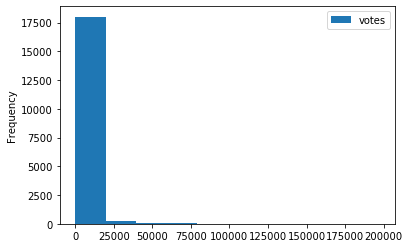

In [85]:
%matplotlib inline 
votes=ptDf.select("votes")
votes_toP=votes.toPandas()
votes_toP.plot.hist()

### 이진 분류 대상 정하기
- 답변 여부에 대해 분류하기에는 표준편차가 너무 크고 모수가 적어 분류 데이터로 적합하지 않아, 
    **투표수를 평균보다 높게 혹은 적게 받는지 예측하는 것**으로 변경하였다.

In [10]:
# 평균 투표수 구하기
tmp = ptDf.agg({"votes":"avg"}).collect()
votes_mean = tmp[0]['avg(votes)']
print(votes_mean)

1784.9046477415136


In [11]:
# 'votes_pos_neg'이라는 새로운 컬럼 생성
# 투표수가 평균을 넘으면 1로 세팅
from pyspark.sql.types import IntegerType

isOverMean = udf(lambda x: 1 if x > votes_mean else 0, IntegerType())
ptDf=ptDf.withColumn("votes_pos_neg",isOverMean(ptDf.votes))

In [18]:
ptDf.printSchema()
ptDf.show(3)

root
 |-- article_id: integer (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- end: timestamp (nullable = true)
 |-- answered: integer (nullable = true)
 |-- votes: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)
 |-- answer: boolean (nullable = true)
 |-- votes_pos_neg: integer (nullable = true)

+----------+-------------------+-------------------+--------+-----+---------+----------------------------------+----------------------------------+------+-------------+
|article_id|              start|                end|answered|votes| category|                             title|                           content|answer|votes_pos_neg|
+----------+-------------------+-------------------+--------+-----+---------+----------------------------------+----------------------------------+------+-------------+
|        21|2017-08-19 00:00:00|2017-11-17 00:00:00|       0|    9|안전/환경|스텔라 데이지호에 대한 

### 토큰화

In [12]:
from pyspark.ml.feature import Tokenizer
_tokenizer = Tokenizer(inputCol="title", outputCol="content_tok")

In [13]:
tokDf = _tokenizer.transform(ptDf)

In [14]:
tokDf.select('content_tok').show(2)

+------------------------------+
|                   content_tok|
+------------------------------+
|  [소액주주를, 보호해주십시오]|
|[『국가유공자, 등, 예우, 및...|
+------------------------------+
only showing top 2 rows



### 불용어 처리
- 참고한 한국어 불용어 분류기 :https://raw.githubusercontent.com/6/stopwords-json/master/dist/ko.json

In [15]:
from pyspark.ml.feature import StopWordsRemover
stop = StopWordsRemover(inputCol="content_tok", outputCol="nostops")

stopwords=list()
_stopwords=stop.getStopWords()
for e in _stopwords:
    stopwords.append(e)

_mystopwords=["\n","저는","","!","\"","$","%","&","'","(",")","*","+",",","-",".","...","0","1","2","3","4","5","6","7","8","9",";","<","=",">","?","@","\\","^","_","`","|","~","·","—","——","‘","’","“","”","…","、","。","〈","〉","《","》","가","가까스로","가령","각","각각","각자","각종","갖고말하자면","같다","같이", "다시", "개의치않고","거니와","거바","거의","것","것과 같이","것들","게다가","게우다","겨우","견지에서","결과에 이르다","결국","결론을 낼 수 있다","겸사겸사","고려하면","고로","곧","공동으로","과","과연","관계가 있다","관계없이","관련이 있다","관하여","관한","관해서는","구","구체적으로","구토하다","그","그들","그때","그래","그래도","그래서","그러나","그러니","그러니까","그러면","그러므로","그러한즉","그런 까닭에","그런데","그런즉","그럼","그럼에도 불구하고","그렇게 함으로써","그렇지","그렇지 않다면","그렇지 않으면","그렇지만","그렇지않으면","그리고","그리하여","그만이다","그에 따르는","그위에","그저","그중에서","그치지 않다","근거로","근거하여","기대여","기점으로","기준으로","기타","까닭으로","까악","까지","까지 미치다","까지도","꽈당","끙끙","끼익","나","나머지는","남들","남짓","너","너희","너희들","네","넷","년","논하지 않다","놀라다","누가 알겠는가","누구","다른","다른 방면으로","다만","다섯","다소","다수","다시 말하자면","다시말하면","다음","다음에","다음으로","단지","답다","당신","당장","대로 하다","대하면","대하여","대해 말하자면","대해서","댕그","더구나","더군다나","더라도","더불어","더욱더","더욱이는","도달하다","도착하다","동시에","동안","된바에야","된이상","두번째로","둘","둥둥","뒤따라","뒤이어","든간에","들","등","등등","딩동","따라","따라서","따위","따지지 않다","딱","때","때가 되어","때문에","또","또한","뚝뚝","라 해도","령","로","로 인하여","로부터","로써","륙","를","마음대로","마저","마저도","마치","막론하고","만 못하다","만약","만약에","만은 아니다","만이 아니다","만일","만큼","말하자면","말할것도 없고","매","매번","메쓰겁다","몇","모","모두","무렵","무릎쓰고","무슨","무엇","무엇때문에","물론","및","바꾸어말하면","바꾸어말하자면","바꾸어서 말하면","바꾸어서 한다면","바꿔 말하면","바로","바와같이","밖에 안된다","반대로","반대로 말하자면","반드시","버금","보는데서","보다더","보드득","본대로","봐","봐라","부류의 사람들","부터","불구하고","불문하고","붕붕","비걱거리다","비교적","비길수 없다","비로소","비록","비슷하다","비추어 보아","비하면","뿐만 아니라","뿐만아니라","뿐이다","삐걱","삐걱거리다","사","삼","상대적으로 말하자면","생각한대로","설령","설마","설사","셋","소생","소인","솨","쉿","습니까","습니다","시각","시간","시작하여","시초에","시키다","실로","심지어","아","아니","아니나다를가","아니라면","아니면","아니었다면","아래윗","아무거나","아무도","아야","아울러","아이","아이고","아이구","아이야","아이쿠","아하","아홉","안 그러면","않기 위하여","않기 위해서","알 수 있다","알았어","앗","앞에서","앞의것","야","약간","양자","어","어기여차","어느","어느 년도","어느것","어느곳","어느때","어느쪽","어느해","어디","어때","어떠한","어떤","어떤것","어떤것들","어떻게","어떻해","어이","어째서","어쨋든","어쩔수 없다","어찌","어찌됏든","어찌됏어","어찌하든지","어찌하여","언제","언젠가","얼마","얼마 안 되는 것","얼마간","얼마나","얼마든지","얼마만큼","얼마큼","엉엉","에","에 가서","에 달려 있다","에 대해","에 있다","에 한하다","에게","에서","여","여기","여덟","여러분","여보시오","여부","여섯","여전히","여차","연관되다","연이서","영","영차","옆사람","예","예를 들면","예를 들자면","예컨대","예하면","오","오로지","오르다","오자마자","오직","오호","오히려","와","와 같은 사람들","와르르","와아","왜","왜냐하면","외에도","요만큼","요만한 것","요만한걸","요컨대","우르르","우리","우리들","우선","우에 종합한것과같이","운운","월","위에서 서술한바와같이","위하여","위해서","윙윙","육","으로","으로 인하여","으로서","으로써","을","응","응당","의","의거하여","의지하여","의해","의해되다","의해서","이","이 되다","이 때문에","이 밖에","이 외에","이 정도의","이것","이곳","이때","이라면","이래","이러이러하다","이러한","이런","이럴정도로","이렇게 많은 것","이렇게되면","이렇게말하자면","이렇구나","이로 인하여","이르기까지","이리하여","이만큼","이번","이봐","이상","이어서","이었다","이와 같다","이와 같은","이와 반대로","이와같다면","이외에도","이용하여","이유만으로","이젠","이지만","이쪽","이천구","이천육","이천칠","이천팔","인 듯하다","인젠","일","일것이다","일곱","일단","일때","일반적으로","일지라도","임에 틀림없다","입각하여","입장에서","잇따라","있다","자","자기","자기집","자마자","자신","잠깐","잠시","저","저것","저것만큼","저기","저쪽","저희","전부","전자","전후","점에서 보아","정도에 이르다","제","제각기","제외하고","조금","조차","조차도","졸졸","좀","좋아","좍좍","주룩주룩","주저하지 않고","줄은 몰랏다","줄은모른다","중에서","중의하나","즈음하여","즉","즉시","지든지","지만","지말고","진짜로","쪽으로","차라리","참","참나","첫번째로","쳇","총적으로","총적으로 말하면","총적으로 보면","칠","콸콸","쾅쾅","쿵","타다","타인","탕탕","토하다","통하여","툭","퉤","틈타","팍","팔","퍽","펄렁","하","하게될것이다","하게하다","하겠는가","하고 있다","하고있었다","하곤하였다","하구나","하기 때문에","하기 위하여","하기는한데","하기만 하면","하기보다는","하기에","하나","하느니","하는 김에","하는 편이 낫다","하는것도","하는것만 못하다","하는것이 낫다","하는바","하더라도","하도다","하도록시키다","하도록하다","하든지","하려고하다","하마터면","하면 할수록","하면된다","하면서","하물며","하여금","하여야","하자마자","하지 않는다면","하지 않도록","하지마","하지마라","하지만","하하","한 까닭에","한 이유는","한 후","한다면","한다면 몰라도","한데","한마디","한적이있다","한켠으로는","한항목","할 따름이다","할 생각이다","할 줄 안다","할 지경이다","할 힘이 있다","할때","할만하다","할망정","할뿐","할수있다","할수있어","할줄알다","할지라도","할지언정","함께","해도된다","해도좋다","해봐요","해서는 안된다","해야한다","해요","했어요","향하다","향하여","향해서","허","허걱","허허","헉","헉헉","헐떡헐떡","형식으로 쓰여","혹시","혹은","혼자","훨씬","휘익","휴","흐흐","흥","힘입어", "있는", "했습니다", "있습니다", "합니다", "경우에도", "때문입니다", "것이나", "︿","！","＃","＄","％","＆","（","）","＊","＋","，","０","１","２","３","４","５","６","７","８","９","：","；","＜","＞","？","＠","［","］","｛","｜","｝","～","￥","\n", "하는", "대한", "합니다", "없는", "하고", "현재", "많은", "같은", "것입니다", "아니라", "지금", "위해", "것은", "대해", "그런", "너무", "일을", "또는", "하였습니다", "하고 있습니다", "하는데", "있어서", "해도", "받는", "받은", "더이상", "그들의", "주시기 바랍니다", "인한", "당연히", "라는", "않는", "인한", "합니다", "있습니다", "아닌", "인해", "수많은"]
for e in _mystopwords:
    stopwords.append(e)
    stopwords.append(e+".")
stop.setStopWords(stopwords)

stopDf = stop.transform(tokDf)
# stopDf.printSchema()
# stopDf.select("nostops").show(1,truncate=False)

In [23]:
stopDf.select('nostops').show()

+---------------------------------+
|                          nostops|
+---------------------------------+
|[스텔라, 데이지호에, 제안입니다.]|
|    [비리제보처를, 만들어주세요.]|
|                [제2의, 개성공단]|
| [공공기관, 무조건적인, 정규직...|
|                [제2의, 개성공단]|
|    [보건복지부, 부령, 제339호...|
|   [김이수, 헌재소장, 임명, 재...|
|     [소액주주를, 보호해주십시오]|
| [문재인, 정부는, 공무원개혁엔...|
|      [a/s, 기사들도, 관심을, ...|
|    [<담배, 제조, 매매금지, 법...|
|  [소액주주, 보호를, 조사요청,...|
|   [납득할, 수, 장애, 재판정을...|
|  [『국가유공자, 예우, 지원에,...|
| [문재인정부는, 신한국형, 페리...|
|     [한국채식인구, 100만명., ...|
| [황우석박사님, 연구재개, 허용...|
|   [한중관계, 사드, 갈등, 해소...|
| [국가유공자등, 예우및, 지우너...|
| [국가유공자등, 예우및, 지우너...|
+---------------------------------+
only showing top 20 rows



### 전처리된 단어들 기반 워드클라우드

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(
                        font_path = '/home/jovyan/font.ttf', 
                        background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

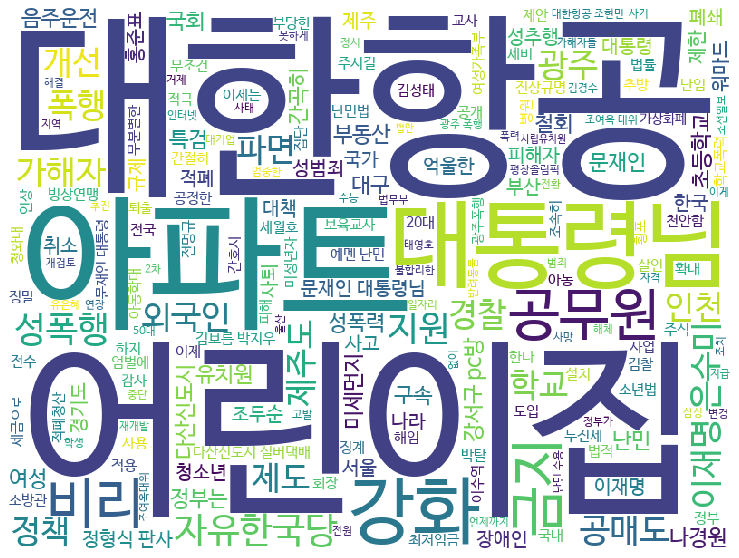

In [17]:
# 계속 워드클라우드의 형태를 확인하면서 직접 불용어 제거
tmp = stopDf.select("nostops").collect()
wordList=[]
selfStopWords=['전면','의','개정','니다','요','오','청원','제발','국민','을','모든','반대','관련','폐지','처벌','위한','대한민국','강력한','갑질','조사','철저','있게','만들'
              ,'촉구','즉각','절대','문제','강력','시다','를','도록','의한','사건','해야','시기','수사','불법','따른','대로']

def selfStop(t):
    for s in selfStopWords:
        if s in t:return False
    return True

for tm in tmp:
    for t in tm['nostops']:
        if len(t)>10 : continue
        if selfStop(t): wordList.append(t)

displayWordCloud(' '.join(wordList))

---

## 3. 학습데이터와 검증데이터 쪼개기

- Pandas dataframe으로 변환 후 train,test data를 7:3의 비율로 split
- CountVectorizer 매칭을 위해 list값들을 하나의 str로 변환해준다.

In [18]:
# Spark df -> Pandas df
ptDf_p = stopDf.toPandas()

In [19]:
type(ptDf_p)

pandas.core.frame.DataFrame

In [20]:
# row에 인덱스 생성
ptDf_p = ptDf_p.reindex()

In [211]:
ptDf_p.shape

(18353, 12)

In [31]:
# 벡터화를 위해ㅣist 타입의 전처리값들을 str으로 변환
def preprocess_stopwords(text):
    preProcessList=[]
    for list in text:
        preProcessList.append(list)
    return ' '.join(preProcessList)

ptDf_p['content_preprocessing'] =  ptDf_p['nostops'].apply(preprocess_stopwords)

In [34]:
split_count = int(ptDf_p.shape[0] * 0.7)
split_count

12847

In [35]:
# 0번째 ~ split_count 인덱스까지의 row들을 학습 데이터로
df_train = ptDf_p[:split_count].copy()
df_train.shape

(12847, 13)

In [86]:
df_train.head(3)

,article_id,start,end,answered,votes,category,title,content,answer,votes_pos_neg,content_tok,nostops,content_preprocessing
0,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,"""** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액...",False,1,"[소액주주를, 보호해주십시오]","[소액주주를, 보호해주십시오]",소액주주를 보호해주십시오
1,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,"""(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 ...",False,0,"[『국가유공자, 등, 예우, 및, 지원에, 관한법률』상「6.25전몰군경, 자녀수당」...","[『국가유공자, 예우, 지원에, 관한법률』상「6.25전몰군경, 자녀수당」의, 불합리...",『국가유공자 예우 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 문제점 ...
2,37,2017-08-19,2017-09-18,0,415,기타,황우석박사님 연구재개 허용 촉구합니다.,국민의 70% 이상이 황우석박사님을 응원하고 지지하고 있습니다.\n*2007년 1월...,False,0,"[황우석박사님, 연구재개, 허용, 촉구합니다.]","[황우석박사님, 연구재개, 허용, 촉구합니다.]",황우석박사님 연구재개 허용 촉구합니다.


In [39]:
# 학습 데이터에서 투표수가 평균보다 많은 건
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(1630, 13)

In [40]:
# split_count ~ 끝 인덱스까지의 row들을 검증 데이터로
df_test = ptDf_p[split_count:].copy()
df_test.shape

(5506, 13)

In [87]:
df_test.head(3)

,article_id,start,end,answered,votes,category,title,content,answer,votes_pos_neg,content_tok,nostops,content_preprocessing,votes_pos_neg_pred,pred_diff
12847,365156,2018-09-03,2018-10-03,0,123,보건복지,국립소록도병원 자원봉사자 관리자임명과 관리 시스템 꼭 개선 해주세요,존경하는 박능후 보건복지부 장관님\n국립소록도 병원에 전문 자원봉사 관리자 임명하여...,False,0,"[국립소록도병원, 자원봉사자, 관리자임명과, , 관리, 시스템, 꼭, 개선, 해주세요]","[국립소록도병원, 자원봉사자, 관리자임명과, 관리, 시스템, 꼭, 개선, 해주세요]",국립소록도병원 자원봉사자 관리자임명과 관리 시스템 꼭 개선 해주세요,0,0
12848,365157,2018-09-03,2018-10-03,0,209,교통/건축/국토,"경남(거제,울산,창원 등등) 집값 하락 대책마련",뉴스에는 서울 집값 안정화만 얘기가 나오는데 서울시민만 이 나라 국민 아닙니다.\n...,False,0,"[경남(거제,울산,창원, 등등), 집값, 하락, 대책마련]","[경남(거제,울산,창원, 등등), 집값, 하락, 대책마련]","경남(거제,울산,창원 등등) 집값 하락 대책마련",0,0
12849,365167,2018-09-03,2018-10-03,0,120,정치개혁,엘리엇 소송에 대한 법무부 답변,엘리엇 소송에 대한 법무부 답변과 이를 작성한 담당 과장의 특채 배경에 대해 진상 ...,False,0,"[엘리엇, 소송에, 대한, 법무부, 답변]","[엘리엇, 소송에, 법무부, 답변]",엘리엇 소송에 법무부 답변,0,0


In [42]:
# 검증 데이터에서 투표수가 평균보다 많은 건
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(668, 13)

---

## 4. 기계학습용 특징 추출하기
### 단어 벡터화 하기 : BOW(bag of words)

* 미리 전처리 해둔 텍스트 데이터로 사이킷런의 CountVectorizer를 사용하여 벡터화한다.
* 의미없는 특성을 많이 생성하기 때문에 적어도 두 번이상 문서에 나타난 토큰만을 사용한다.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 벡터화 단위
                             tokenizer = None, # 전처리를 완료하였으니 사용 X
                             preprocessor = None, # 전처리를 완료하였으니 사용 X
                             stop_words = None, # 전처리를 완료하였으니 사용 X
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정함으로써 bow의 단점 개선
                             max_features = 2000 # 만들 피처의 수(단어의 수)
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=2,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [44]:
# 학습데이터 벡터화
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing'])
train_feature_vector.shape

(12847, 2000)

In [45]:
# 검증데이터 벡터화
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing'])
test_feature_vector.shape

(5506, 2000)

In [90]:
vocabulary = vectorizer.get_feature_names()
print(len(vocabulary))
vocabulary[:10]

2000


['10', '100', '10년', '10년 공공임대', '10월', '10월부터', '12', '18', '1월부터', '1인']

In [47]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocabulary)

,10,100,10년,10년 공공임대,10월,10월부터,12,18,1월부터,1인,...,회장,회장을,회장의,횡령,횡포,횡포를,횡포에,휴게시간,희망을,힘을
0,6,21,11,11,8,13,7,11,15,9,...,9,32,10,8,6,10,9,6,11,14


### TF-IDF
#### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정한다. 
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부


In [48]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [49]:
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

(12847, 2000)

In [50]:
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

(5506, 2000)

---

## 5. 랜덤포레스트로 학습시기키
* 참고 링크: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* 랜덤포레스트 분류기를 사용함으로써 과적합(overfitting)을 방지한다.

In [51]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2018, verbose=0,
                       warm_start=False)

In [52]:
# 투표 건의 평균이 넘는지 확인 가능한 컬럼데이터를 학습에 사용할 y_label 삽입
y_label = df_train['votes_pos_neg']
forest = forest.fit(train_feature_tfidf, y_label)

---

## 6. 평가하기

In [53]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

array([0.84474708, 0.84124514, 0.84546516, 0.8388478 , 0.84351888])

In [70]:
np.round(np.mean(score)*100,2)

84.28

---

## 7. 예측하기

In [71]:
# 검증 데이터 넣고 예측
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [72]:
y_pred.shape

(5506,)

In [73]:
# 예측 결과를 저장할 dataframe 생성
output = pd.DataFrame(data={'votes_pos_neg_pred':y_pred})
output.head(3)

,votes_pos_neg_pred
0,0
1,0
2,0


In [74]:
# 0과 1이 어떻게 집계되었는지 확인
output['votes_pos_neg_pred'].value_counts()

0    5316
1     190
Name: votes_pos_neg_pred, dtype: int64

In [76]:
# 예측에 성공했는지 실패했는지 담을 컬럼 'pred_diff' 생성
df_test['votes_pos_neg_pred'] = y_pred

df_test['pred_diff'] = np.abs(df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred'])
df_test.head()

,article_id,start,end,answered,votes,category,title,content,answer,votes_pos_neg,content_tok,nostops,content_preprocessing,votes_pos_neg_pred,pred_diff
12847,365156,2018-09-03,2018-10-03,0,123,보건복지,국립소록도병원 자원봉사자 관리자임명과 관리 시스템 꼭 개선 해주세요,존경하는 박능후 보건복지부 장관님\n국립소록도 병원에 전문 자원봉사 관리자 임명하여...,False,0,"[국립소록도병원, 자원봉사자, 관리자임명과, , 관리, 시스템, 꼭, 개선, 해주세요]","[국립소록도병원, 자원봉사자, 관리자임명과, 관리, 시스템, 꼭, 개선, 해주세요]",국립소록도병원 자원봉사자 관리자임명과 관리 시스템 꼭 개선 해주세요,0,0
12848,365157,2018-09-03,2018-10-03,0,209,교통/건축/국토,"경남(거제,울산,창원 등등) 집값 하락 대책마련",뉴스에는 서울 집값 안정화만 얘기가 나오는데 서울시민만 이 나라 국민 아닙니다.\n...,False,0,"[경남(거제,울산,창원, 등등), 집값, 하락, 대책마련]","[경남(거제,울산,창원, 등등), 집값, 하락, 대책마련]","경남(거제,울산,창원 등등) 집값 하락 대책마련",0,0
12849,365167,2018-09-03,2018-10-03,0,120,정치개혁,엘리엇 소송에 대한 법무부 답변,엘리엇 소송에 대한 법무부 답변과 이를 작성한 담당 과장의 특채 배경에 대해 진상 ...,False,0,"[엘리엇, 소송에, 대한, 법무부, 답변]","[엘리엇, 소송에, 법무부, 답변]",엘리엇 소송에 법무부 답변,0,0
12850,365194,2018-09-03,2018-10-03,0,212,교통/건축/국토,화물차 과적제도에 관한 건,안녕하십니까.\n화물차 과적제도의 오류에 관해 여쭤보고 싶습니다.\n화물업계를 모르...,False,0,"[화물차, 과적제도에, 관한, 건]","[화물차, 과적제도에, 건]",화물차 과적제도에 건,0,0
12851,365199,2018-09-03,2018-10-03,0,192,문화/예술/체육/언론,"선동열 병역비리 조사 청원합니다,","선동열은 말도 안된 선수을 선발 해서 병역면제을 받게 만든 병역 브로커 입니다,\n...",False,0,"[선동열, 병역비리, 조사, 청원합니다,]","[선동열, 병역비리, 조사, 청원합니다,]","선동열 병역비리 조사 청원합니다,",0,0


In [79]:
# 예측이 맞았는지 집계
pred_diff = df_test['pred_diff'].value_counts()
print(pred_diff)

print('전체 {}건의 데이터 중 {}건 예측 성공'.format(y_pred.shape[0], pred_diff[0]))

0    4684
1     822
Name: pred_diff, dtype: int64
전체 5506건의 데이터 중 4684건 예측 성공


In [82]:
# 예측 비율
acc = ( pred_diff[0] / y_pred.shape[0] ) *100 
print('예측 비율 : {} '.format(acc))

예측 비율 : 85.07083181983292 
